In [1]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")
houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)

train = train.drop(outliers.index)
labels = labels.drop(outliers.index)

Number of Outliers: 37
Percent Removed: 2.33%



In [135]:
features_a = pd.DataFrame(index=train.index)
features_a['tot_pwr'] = train.sum(axis=1)
features_a['avg_pwr'] = train.mean(axis=1)
features_a['median_pwr'] = train.median(axis=1)
features_a['min_pwr'] = train.min(axis=1)
features_a['max_pwr'] = train.max(axis=1)
features_a['tot_chrgs'] = labels.sum(axis=1)
features_a['label'] = np.where(features_a['tot_chrgs'] > 0, True, False)

features_a['median_pwr_2'] = features_a['median_pwr']**2
features_a['max_pwr_2'] = features_a['max_pwr']**2
features_a['max_pwr_3'] = features_a['max_pwr']**3

print(features_a.columns)

Index(['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'tot_chrgs',
       'label', 'median_pwr_2', 'max_pwr_2', 'max_pwr_3'],
      dtype='object')


In [138]:
# ['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'diff_avg', 'diff_max', 'h8_avg', 'h24_avg', 'h72_avg']
X = features_a[['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'median_pwr_2', 'max_pwr_2', 'max_pwr_3']]
y = features_a[['label']]

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


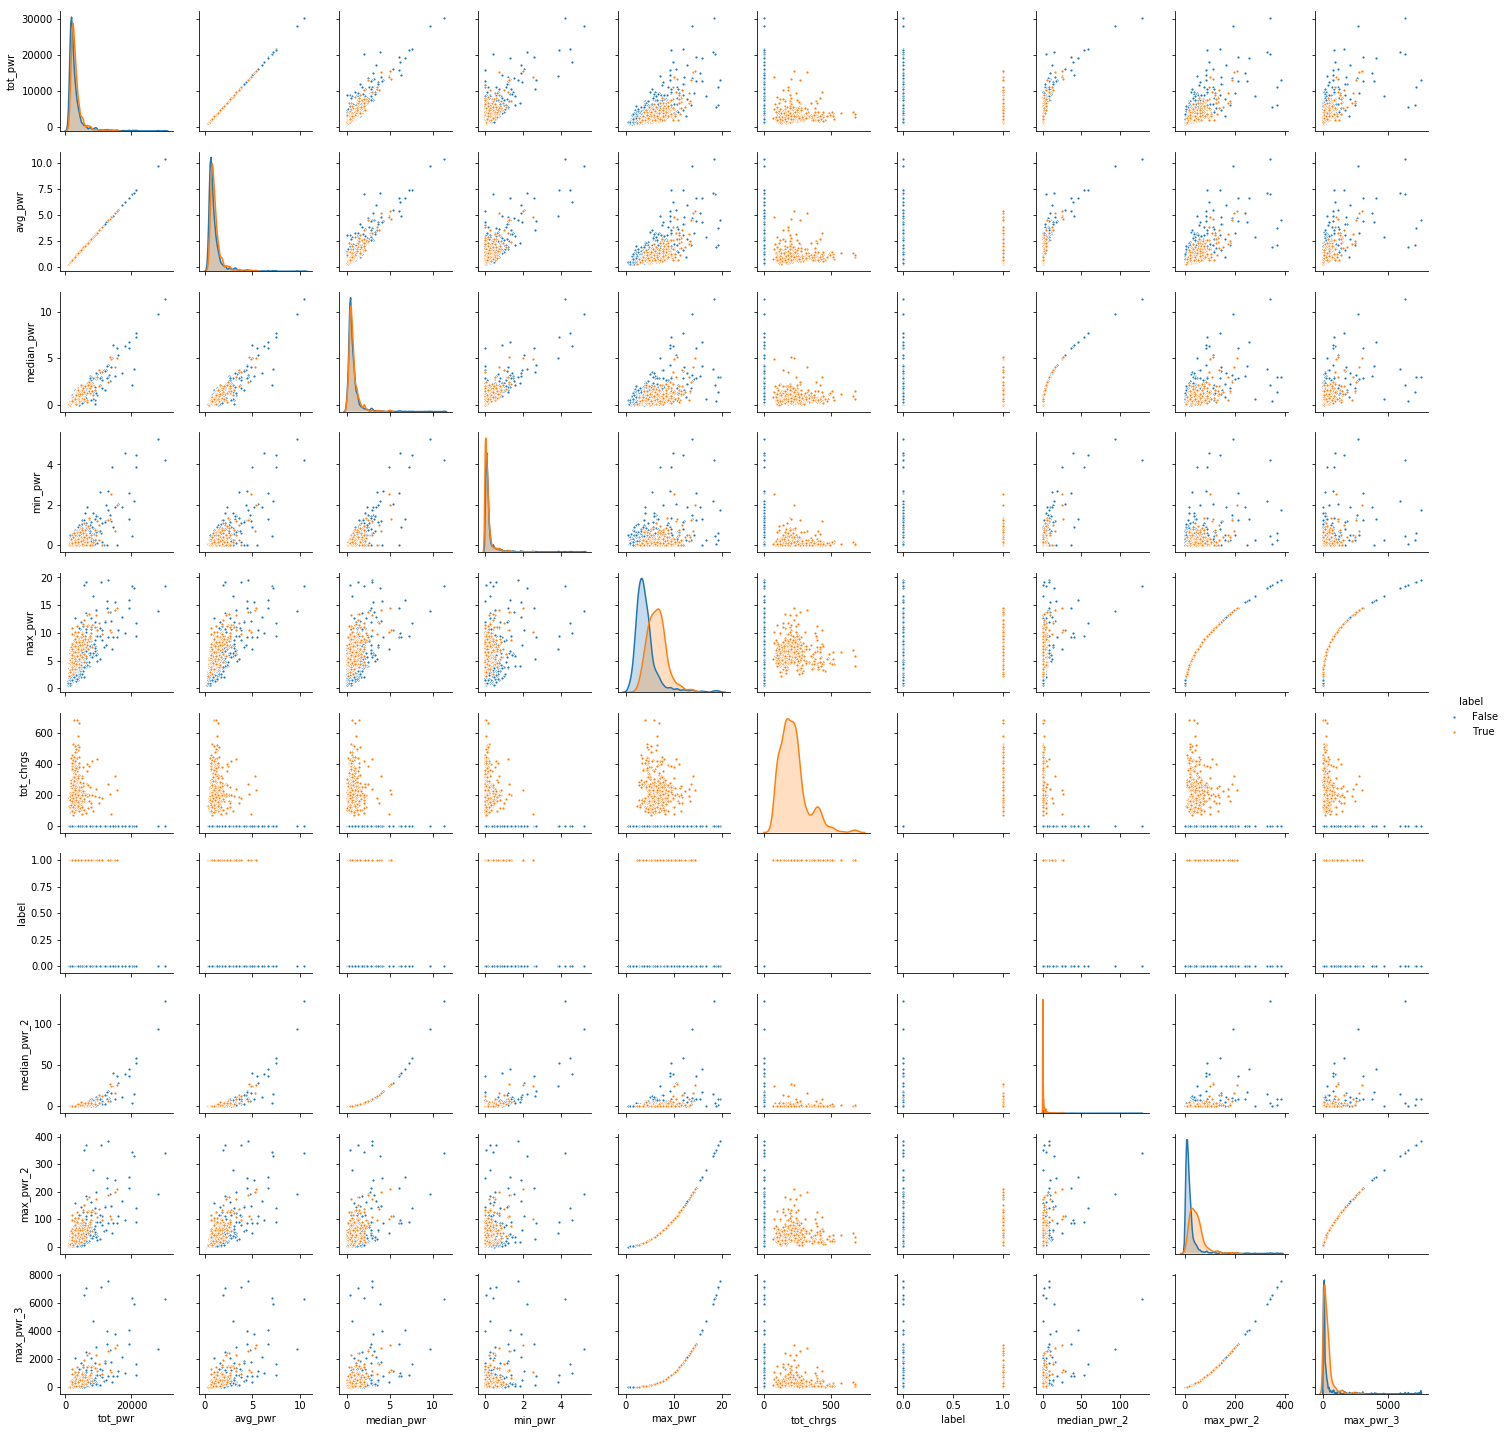

In [146]:
fig = sns.pairplot(features_a, height=2, hue='label', markers='.');

In [143]:
# Try different sets of features
# ['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'tot_chrgs','label']
X1 = X[['avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr']]
X2 = X[['avg_pwr', 'min_pwr', 'max_pwr']]
X3 = X[['tot_pwr']]
X4 = X[['avg_pwr']]
X5 = X[['median_pwr']]
X6 = X[['min_pwr']]
X7 = X[['max_pwr']]
X8 = X[['avg_pwr', 'max_pwr']]

X9 = X[['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'median_pwr_2', 'max_pwr_2']]
X10 = X[['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'median_pwr_2', 'max_pwr_2']]
X11 = X[['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'max_pwr_2', 'max_pwr_3']]
X12 = X[['tot_pwr', 'avg_pwr', 'median_pwr', 'max_pwr', 'max_pwr_2', 'max_pwr_3']]
XN = X[['avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr']]
XN = X[['avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr']]

cases = [X, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12]

In [144]:
# Test feature sets
scores = pd.DataFrame()
for i, X_case in enumerate(cases):
    
    X_train, X_test, y_train, y_test = utils.scale_split_data(X_case,y)

    # Train logistic regression model
    logreg = LogisticRegression(solver='liblinear', random_state=0)
    logreg.fit(X_train, np.ravel(y_train))
    scores = scores.append({'score': logreg.score(X_test, y_test), 
                           'cols': X_case.columns.tolist()}, 
                           ignore_index=True)
    
scores.sort_values('score', ascending=False)

,cols,score
11,"[tot_pwr, avg_pwr, median_pwr, min_pwr, max_pw...",0.843188
12,"[tot_pwr, avg_pwr, median_pwr, max_pwr, max_pw...",0.843188
0,"[tot_pwr, avg_pwr, median_pwr, min_pwr, max_pw...",0.840617
9,"[tot_pwr, avg_pwr, median_pwr, min_pwr, max_pw...",0.838046
10,"[tot_pwr, avg_pwr, median_pwr, min_pwr, max_pw...",0.838046
1,"[avg_pwr, median_pwr, min_pwr, max_pwr]",0.827763
2,"[avg_pwr, min_pwr, max_pwr]",0.827763
8,"[avg_pwr, max_pwr]",0.825193
7,[max_pwr],0.727506
3,[tot_pwr],0.686375


In [10]:
# Try different sets of features
# ['value', 'diff', 'h8_avg', 'h24_avg', 'h24_min', 'h24_max', 'h72_avg','diff_2', 'diff_3', 'diff_5']
X0 = X[['value', 'diff', 'h24_avg', 'h72_avg']]
X1 = X[['diff', 'h24_avg', 'h72_avg']]
X2 = X[['value', 'h24_avg', 'h72_avg']]
X3 = X[['value', 'diff', 'h72_avg']]
X4 = X[['value', 'diff', 'h24_avg']]
X5 = X[['value']]
X6 = X[['diff']]
X7 = X[['diff', 'value']]

X8 = X[['value', 'h8_avg', 'h24_avg', 'h72_avg']]
X9 = X[['value', 'diff', 'h24_min', 'h24_max']]
X10 = X[['value', 'h24_min', 'h24_max']]
X11 = X[['value', 'diff', 'h8_avg']]
X12 = X[['diff','diff_2', 'diff_3', 'diff_5']]
X13 = X[['value', 'h8_avg','diff_3']]


cases = [X, X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13]

In [11]:
# Test feature sets
scores = pd.DataFrame()
for i, X_case in enumerate(cases):
    
    X_train, X_test, y_train, y_test = utils.scale_split_data(X_case,y)

    # Train logistic regression model
    logreg = LogisticRegression(solver='liblinear', random_state=0)
    logreg.fit(X_train, y_train)
    scores = scores.append({'score': logreg.score(X_test, y_test), 
                           'cols': X_case.columns.tolist()}, 
                           ignore_index=True)
    
scores.sort_values('score', ascending=False)


,cols,score
0,"[value, diff, h8_avg, h24_avg, h24_min, h24_ma...",0.945535
9,"[value, h8_avg, h24_avg, h72_avg]",0.944575
3,"[value, h24_avg, h72_avg]",0.944560
1,"[value, diff, h24_avg, h72_avg]",0.944336
5,"[value, diff, h24_avg]",0.943569
4,"[value, diff, h72_avg]",0.943431
11,"[value, h24_min, h24_max]",0.937695
12,"[value, diff, h8_avg]",0.937297
10,"[value, diff, h24_min, h24_max]",0.937086
14,"[value, h8_avg, diff_3]",0.936989


Note, we see a worse score by only training for EV houses.